# Iron Ore Indicator - Comprehensive P&L Analysis

**Strategy**: 7-Indicator Confirmation System with Market Regime Detection

**Date**: 2025-11-05

**Instrument**: DCE/i<00> (Iron Ore)

**Period**: 2024-10-01 to 2024-12-31 (3 months evaluation)

**Purpose**: Backtest performance analysis with regime-aware trading simulation

---

## Strategy Overview

### Seven Technical Indicators:
1. **Triple EMA** (12/26/50) - Trend identification
2. **MACD** (12/26/9) - Momentum confirmation
3. **RSI** (14) - Mean reversion signals
4. **Bollinger Bands** (20, 2σ) - Price extremes
5. **ATR** (14) - Volatility measurement
6. **BB Width** - Volatility confirmation
7. **Volume EMA** (20) - Liquidity confirmation

### Four Market Regimes:
1. **Strong Uptrend** - Momentum long entries
2. **Strong Downtrend** - Momentum short entries
3. **Sideways/Ranging** - Mean reversion trades
4. **High Volatility Chaos** - No trading (capital preservation)

## 1. Setup and Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
import svr3
from datetime import datetime

%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Jupyter async support
try:
    import nest_asyncio
    nest_asyncio.apply()
    print("✓ nest_asyncio enabled")
except ImportError:
    print("⚠️ Install nest-asyncio: pip install nest-asyncio")

# Load environment
from dotenv import load_dotenv
load_dotenv()

SVR_HOST = os.getenv("SVR_HOST")
SVR_TOKEN = os.getenv("SVR_TOKEN")

if not SVR_HOST or not SVR_TOKEN:
    print("❌ Error: SVR_HOST or SVR_TOKEN not found in .env file")
else:
    print(f"✓ Environment loaded: {SVR_HOST}")

✓ nest_asyncio enabled
✓ Environment loaded: 10.99.100.116


## 2. Data Fetching from SVR3 Server

In [2]:
async def fetch_indicator_data(start_date, end_date):
    """
    Fetch indicator data from svr3 server.
    
    Args:
        start_date: int format YYYYMMDDHHMMSS
        end_date: int format YYYYMMDDHHMMSS
    """
    print(f"📥 Fetching indicator data from {start_date} to {end_date}...")
    
    # Server configuration
    RAILS_URL = f"https://{SVR_HOST}:4433/private-api/"
    WS_URL = f"wss://{SVR_HOST}:4433/tm"
    TM_MASTER = (SVR_HOST, 6102)
    
    try:
        # Create reader
        reader = svr3.sv_reader(
            start_date,          # start
            end_date,            # end
            "IronOreIndicatorRelaxed",  # algoname
            900,                 # granularity
            "private",           # namespace
            "symbol",            # work_mode
            ["DCE"],             # markets
            ["i<00>"],           # codes
            False,               # persistent
            RAILS_URL,           # rails_url
            WS_URL,              # ws_url
            "",                  # user
            "",                  # hashed_password
            TM_MASTER            # tm_master
        )
        
        # Set token
        reader.token = SVR_TOKEN
        
        # Connection sequence
        print("   🔐 Logging in...")
        await reader.login()
        
        print("   🔌 Connecting...")
        await reader.connect()
        
        print("   🔄 Starting WebSocket loop...")
        reader.ws_task = asyncio.create_task(reader.ws_loop())
        
        print("   🤝 Handshaking...")
        await reader.shakehand()
        
        print("   📊 Fetching data...")
        ret = await reader.save_by_symbol()
        
        # Extract data
        if ret and len(ret) > 1 and len(ret[1]) > 1:
            data = ret[1][1]
        else:
            print("   ⚠️ No data returned")
            return None
        
        if not data or len(data) == 0:
            print("   ⚠️ Empty data")
            return None
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Parse timestamps
        if 'time_tag' in df.columns:
            try:
                import pycaitlynutils3 as pcu3
                df['timestamp'] = pd.to_datetime(df['time_tag'].apply(pcu3.ts_parse))
            except:
                df['timestamp'] = pd.to_datetime(df['time_tag'], unit='ms')
        
        print(f"   ✓ Fetched {len(df)} bars")
        return df
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

async def fetch_price_data(start_date, end_date):
    """
    Fetch price (OHLCV) data from svr3 server.
    """
    print(f"📥 Fetching price data from {start_date} to {end_date}...")
    
    RAILS_URL = f"https://{SVR_HOST}:4433/private-api/"
    WS_URL = f"wss://{SVR_HOST}:4433/tm"
    TM_MASTER = (SVR_HOST, 6102)
    
    try:
        reader = svr3.sv_reader(
            start_date,
            end_date,
            "SampleQuote",      # Fetch OHLCV data
            900,
            "global",            # Global namespace
            "symbol",
            ["DCE"],
            ["i<00>"],
            False,
            RAILS_URL,
            WS_URL,
            "",
            "",
            TM_MASTER
        )
        
        reader.token = SVR_TOKEN
        
        print("   🔐 Logging in...")
        await reader.login()
        await reader.connect()
        reader.ws_task = asyncio.create_task(reader.ws_loop())
        await reader.shakehand()
        
        print("   📊 Fetching data...")
        ret = await reader.save_by_symbol()
        
        if ret and len(ret) > 1 and len(ret[1]) > 1:
            data = ret[1][1]
        else:
            print("   ⚠️ No data returned")
            return None
        
        if not data or len(data) == 0:
            print("   ⚠️ Empty data")
            return None
        
        df = pd.DataFrame(data)
        
        if 'time_tag' in df.columns:
            try:
                import pycaitlynutils3 as pcu3
                df['timestamp'] = pd.to_datetime(df['time_tag'].apply(pcu3.ts_parse))
            except:
                df['timestamp'] = pd.to_datetime(df['time_tag'], unit='ms')
        
        print(f"   ✓ Fetched {len(df)} bars")
        return df
        
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Fetch data for 3-month evaluation period
start_date = 20241025000000  
end_date = 20241101000000 

print("="*70)
print("FETCHING DATA")
print("="*70)

# Fetch both indicator signals and price data
df_indicator = await fetch_indicator_data(start_date, end_date)
df_price = await fetch_price_data(start_date, end_date)

# Merge on timestamp
if df_indicator is not None and df_price is not None:
    df = pd.merge(df_indicator, df_price[['timestamp', 'open', 'high', 'low', 'close', 'volume']], 
                  on='timestamp', how='inner', suffixes=('', '_price'))
    
    print(f"\n✅ Data loaded successfully!")
    print(f"   Rows: {len(df)}")
    print(f"   Columns: {list(df.columns)}")
    print(f"   Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    display(df.head(10))
else:
    print("\n❌ Failed to load data")
    df = None

FETCHING DATA
📥 Fetching indicator data from 20241025000000 to 20241101000000...
   🔐 Logging in...
   🔌 Connecting...
   🔄 Starting WebSocket loop...
   🤝 Handshaking...
   📊 Fetching data...
   ✓ Fetched 114 bars
📥 Fetching price data from 20241025000000 to 20241101000000...
   🔐 Logging in...
   📊 Fetching data...
   ✓ Fetched 115 bars

✅ Data loaded successfully!
   Rows: 114
   Columns: ['time_tag', 'granularity', 'code', 'market', 'struct_market', 'struct_code', 'namespace', '_preserved_field', 'bar_index', 'ema_12', 'ema_26', 'ema_50', 'macd', 'macd_signal', 'macd_histogram', 'rsi', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_width', 'bb_width_pct', 'atr', 'volume_ema', 'regime', 'signal', 'confidence', 'position_state', 'cash', 'contracts_held', 'portfolio_value', 'timestamp', 'open', 'high', 'low', 'close', 'volume']
   Date range: 2024-10-25 01:15:00+00:00 to 2024-10-31 14:45:00+00:00


,time_tag,granularity,code,market,struct_market,struct_code,namespace,_preserved_field,bar_index,ema_12,...,position_state,cash,contracts_held,portfolio_value,timestamp,open,high,low,close,volume
0,1729818900000,900,i<00>,DCE,DCE,i<00>,1,1729818900000,8,764.239872,...,1,992375.0,10,1000015.0,2024-10-25 01:15:00+00:00,765.0,765.5,762.0,762.5,18949
1,1729819800000,900,i<00>,DCE,DCE,i<00>,1,1729819800000,9,764.587584,...,0,1000040.0,0,1000040.0,2024-10-25 01:30:00+00:00,763.0,764.5,761.0,764.0,10913
2,1729820700000,900,i<00>,DCE,DCE,i<00>,1,1729820700000,10,764.343340,...,1,992410.0,10,1000040.0,2024-10-25 01:45:00+00:00,764.0,767.5,763.0,766.5,16401
3,1729821600000,900,i<00>,DCE,DCE,i<00>,1,1729821600000,11,764.752057,...,0,1000080.0,0,1000080.0,2024-10-25 02:00:00+00:00,767.0,767.0,762.5,763.0,10772
4,1729822500000,900,i<00>,DCE,DCE,i<00>,1,1729822500000,12,765.174818,...,0,1000080.0,0,1000080.0,2024-10-25 02:15:00+00:00,763.0,767.0,761.5,767.0,14027
5,1729824300000,900,i<00>,DCE,DCE,i<00>,1,1729824300000,13,765.840230,...,1,992385.0,10,1000080.0,2024-10-25 02:45:00+00:00,766.5,768.0,765.0,767.5,13019
6,1729825200000,900,i<00>,DCE,DCE,i<00>,1,1729825200000,14,766.172502,...,1,992385.0,10,1000065.0,2024-10-25 03:00:00+00:00,767.5,771.0,766.5,769.5,27039
7,1729826100000,900,i<00>,DCE,DCE,i<00>,1,1729826100000,15,766.992117,...,0,1000100.0,0,1000100.0,2024-10-25 03:15:00+00:00,769.0,770.0,767.0,768.0,15252
8,1729827000000,900,i<00>,DCE,DCE,i<00>,1,1729827000000,16,767.685638,...,0,1000100.0,0,1000100.0,2024-10-25 03:30:00+00:00,768.0,772.0,766.0,771.5,16550
9,1729835100000,900,i<00>,DCE,DCE,i<00>,1,1729835100000,17,768.272463,...,0,1000100.0,0,1000100.0,2024-10-25 05:45:00+00:00,770.5,774.0,769.5,771.5,24822


[2025-11-05 18:27:54][INFO]Connection lost
[2025-11-05 18:28:00][INFO]Connection lost


## 3. Extract Trades from Indicator Signals

**Important**: The indicator tracks portfolio value (PV) internally!

- Initial Capital: ¥1,000,000
- Position Size: 10 contracts per trade
- PV tracked in real-time: `portfolio_value`, `cash`, `contracts_held`

Signal interpretation:
- `signal = 1`: BUY (enter long when flat)
- `signal = -1`: SELL (exit long when in position)
- `signal = 0`: NEUTRAL (no action)

In [3]:
def extract_trades(df):
    """
    Extract individual trades from indicator signals.
    The indicator already tracks portfolio value, we just need to extract trade records.
    
    Args:
        df: DataFrame with indicator signals, prices, and portfolio_value
    
    Returns:
        DataFrame with trade results
    """
    print("📊 Extracting trades from signals...")
    
    trades = []
    position = None  # {entry_price, entry_time, regime, confidence}
    
    for idx, row in df.iterrows():
        timestamp = row['timestamp']
        signal = row['signal']
        confidence = row['confidence']
        regime = row['regime']
        close = row['close']
        
        # Process signals
        if signal == 1 and position is None:
            # BUY signal - record entry
            position = {
                'entry_time': timestamp,
                'entry_price': close,
                'regime': regime,
                'confidence': confidence
            }
            
        elif signal == -1 and position is not None:
            # SELL signal - record completed trade
            exit_price = close
            pnl = (exit_price - position['entry_price']) * 10  # 10 contracts
            
            trades.append({
                'entry_time': position['entry_time'],
                'exit_time': timestamp,
                'entry_price': position['entry_price'],
                'exit_price': exit_price,
                'contracts': 10,
                'regime': position['regime'],
                'confidence': position['confidence'],
                'pnl': pnl,
                'return_pct': (exit_price - position['entry_price']) / position['entry_price'] * 100
            })
            
            position = None
    
    trades_df = pd.DataFrame(trades)
    
    print(f"   Total trades: {len(trades_df)}")
    if len(trades_df) > 0:
        print(f"   Total P&L: ¥{trades_df['pnl'].sum():,.2f}")
        print(f"   Winning trades: {(trades_df['pnl'] > 0).sum()}")
        print(f"   Losing trades: {(trades_df['pnl'] < 0).sum()}")
    
    return trades_df

if df is not None:
    # Check if portfolio_value exists
    if 'portfolio_value' not in df.columns:
        print("⚠️ WARNING: portfolio_value not found in indicator data!")
        print("   Available columns:", list(df.columns))
        print("   Please run the indicator first to generate portfolio tracking data.")
    else:
        print(f"✅ Portfolio tracking data found!")
        print(f"   Initial PV: ¥{df['portfolio_value'].iloc[0]:,.2f}")
        print(f"   Final PV: ¥{df['portfolio_value'].iloc[-1]:,.2f}")
        print(f"   Total Return: {(df['portfolio_value'].iloc[-1]/df['portfolio_value'].iloc[0]-1)*100:.2f}%")
    
    # Extract trades
    trades_df = extract_trades(df)
    
    if len(trades_df) > 0:
        print("\n📈 Sample Trades:")
        display(trades_df.head(10))
else:
    print("⚠️ No data available")

✅ Portfolio tracking data found!
   Initial PV: ¥1,000,015.00
   Final PV: ¥1,000,090.00
   Total Return: 0.01%
📊 Extracting trades from signals...
   Total trades: 4
   Total P&L: ¥75.00
   Winning trades: 3
   Losing trades: 1

📈 Sample Trades:


,entry_time,exit_time,entry_price,exit_price,contracts,regime,confidence,pnl,return_pct
0,2024-10-25 01:45:00+00:00,2024-10-25 02:00:00+00:00,766.5,763.0,10,3,0.3281,-35.0,-0.456621
1,2024-10-25 02:45:00+00:00,2024-10-25 03:15:00+00:00,767.5,768.0,10,1,0.0000,5.0,0.065147
2,2024-10-25 07:00:00+00:00,2024-10-25 13:15:00+00:00,769.5,777.5,10,1,0.0000,80.0,1.039636
3,2024-10-25 14:45:00+00:00,2024-10-25 15:00:00+00:00,786.5,789.0,10,1,0.0000,25.0,0.317864


## 4. Performance Metrics

In [4]:
def calculate_metrics(df, trades_df, initial_capital=1000000):
    """
    Calculate comprehensive performance metrics using portfolio_value from indicator.
    """
    if len(trades_df) == 0:
        return None
    
    winning_trades = trades_df[trades_df['pnl'] > 0]
    losing_trades = trades_df[trades_df['pnl'] < 0]
    
    # Use portfolio_value from indicator for equity calculations
    if 'portfolio_value' in df.columns:
        equity_series = df['portfolio_value'].dropna()
    else:
        print("⚠️ WARNING: Using fallback - portfolio_value not found!")
        return None
    
    # Calculate drawdown
    peak = equity_series.expanding().max()
    drawdown = (equity_series - peak) / peak
    max_drawdown = drawdown.min()
    
    final_equity = equity_series.iloc[-1]
    total_return = (final_equity - initial_capital) / initial_capital
    
    metrics = {
        'Total Trades': len(trades_df),
        'Winning Trades': len(winning_trades),
        'Losing Trades': len(losing_trades),
        'Win Rate': len(winning_trades) / len(trades_df) if len(trades_df) > 0 else 0,
        'Total P&L (CNY)': trades_df['pnl'].sum(),
        'Total Return (%)': total_return * 100,
        'Avg Win (CNY)': winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0,
        'Avg Loss (CNY)': losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0,
        'Largest Win (CNY)': winning_trades['pnl'].max() if len(winning_trades) > 0 else 0,
        'Largest Loss (CNY)': losing_trades['pnl'].min() if len(losing_trades) > 0 else 0,
        'Profit Factor': (winning_trades['pnl'].sum() / abs(losing_trades['pnl'].sum())) 
                        if len(losing_trades) > 0 and losing_trades['pnl'].sum() != 0 else np.inf,
        'Sharpe Ratio': (trades_df['return_pct'].mean() / trades_df['return_pct'].std() * np.sqrt(252)) 
                       if trades_df['return_pct'].std() > 0 else 0,
        'Max Drawdown': max_drawdown,
        'Max Drawdown (%)': max_drawdown * 100,
        'Initial Capital (CNY)': initial_capital,
        'Final Equity (CNY)': final_equity
    }
    
    return metrics

if df is not None and 'portfolio_value' in df.columns and len(trades_df) > 0:
    metrics = calculate_metrics(df, trades_df)
    
    print("\n" + "="*70)
    print("PERFORMANCE METRICS")
    print("="*70)
    
    metrics_df = pd.DataFrame([metrics]).T
    metrics_df.columns = ['Value']
    
    # Format rows
    for idx in metrics_df.index:
        if 'Rate' in idx or 'Drawdown (%)' in idx or 'Return (%)' in idx:
            metrics_df.loc[idx, 'Value'] = f"{metrics_df.loc[idx, 'Value']:.2%}"
        elif 'CNY' in idx:
            metrics_df.loc[idx, 'Value'] = f"¥{metrics_df.loc[idx, 'Value']:,.2f}"
        elif idx in ['Sharpe Ratio', 'Profit Factor']:
            metrics_df.loc[idx, 'Value'] = f"{metrics_df.loc[idx, 'Value']:.2f}"
        elif idx in ['Max Drawdown']:
            metrics_df.loc[idx, 'Value'] = f"{metrics_df.loc[idx, 'Value']:.4f}"
    
    display(metrics_df)
    print("="*70)
else:
    print("⚠️ Cannot calculate metrics (no data, no portfolio_value, or no trades)")
    metrics = None


PERFORMANCE METRICS


/tmp/ipykernel_107381/1310962934.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '75.00%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metrics_df.loc[idx, 'Value'] = f"{metrics_df.loc[idx, 'Value']:.2%}"


,Value
Total Trades,4.0
Winning Trades,3.0
Losing Trades,1.0
Win Rate,75.00%
Total P&L (CNY),¥75.00
Total Return (%),0.90%
Avg Win (CNY),¥36.67
Avg Loss (CNY),¥-35.00
Largest Win (CNY),¥80.00
Largest Loss (CNY),¥-35.00


## 5. Regime Analysis

In [5]:
if df is not None:
    print("📊 Market Regime Distribution:")
    print("="*70)
    
    regime_names = {1: 'Strong Uptrend', 2: 'Strong Downtrend', 3: 'Sideways/Ranging', 4: 'High Volatility Chaos'}
    regime_counts = df['regime'].value_counts().sort_index()
    regime_pct = (regime_counts / len(df) * 100).round(2)
    
    regime_summary = pd.DataFrame({
        'Regime': [regime_names[i] for i in regime_counts.index],
        'Bars': regime_counts.values,
        'Percentage': [f"{p}%" for p in regime_pct.values]
    })
    
    display(regime_summary)
    
    # Regime-specific trade performance
    if len(trades_df) > 0:
        print("\n📊 Trade Performance by Regime:")
        print("="*70)
        
        regime_performance = trades_df.groupby('regime').agg({
            'pnl': ['count', 'sum', 'mean'],
            'return_pct': 'mean',
            'confidence': 'mean'
        }).round(2)
        
        regime_performance.index = regime_performance.index.map(regime_names)
        display(regime_performance)

📊 Market Regime Distribution:


,Regime,Bars,Percentage
0,Strong Uptrend,20,17.54%
1,Sideways/Ranging,2,1.75%
2,High Volatility Chaos,92,80.7%



📊 Trade Performance by Regime:


pnl               return_pct confidence
                 count    sum   mean       mean       mean
regime                                                    
Strong Uptrend       3  110.0  36.67       0.47       0.00
Sideways/Ranging     1  -35.0 -35.00      -0.46       0.33

## 6. Comprehensive Visualizations


✅ Comprehensive visualization saved as 'analysis_comprehensive.png'


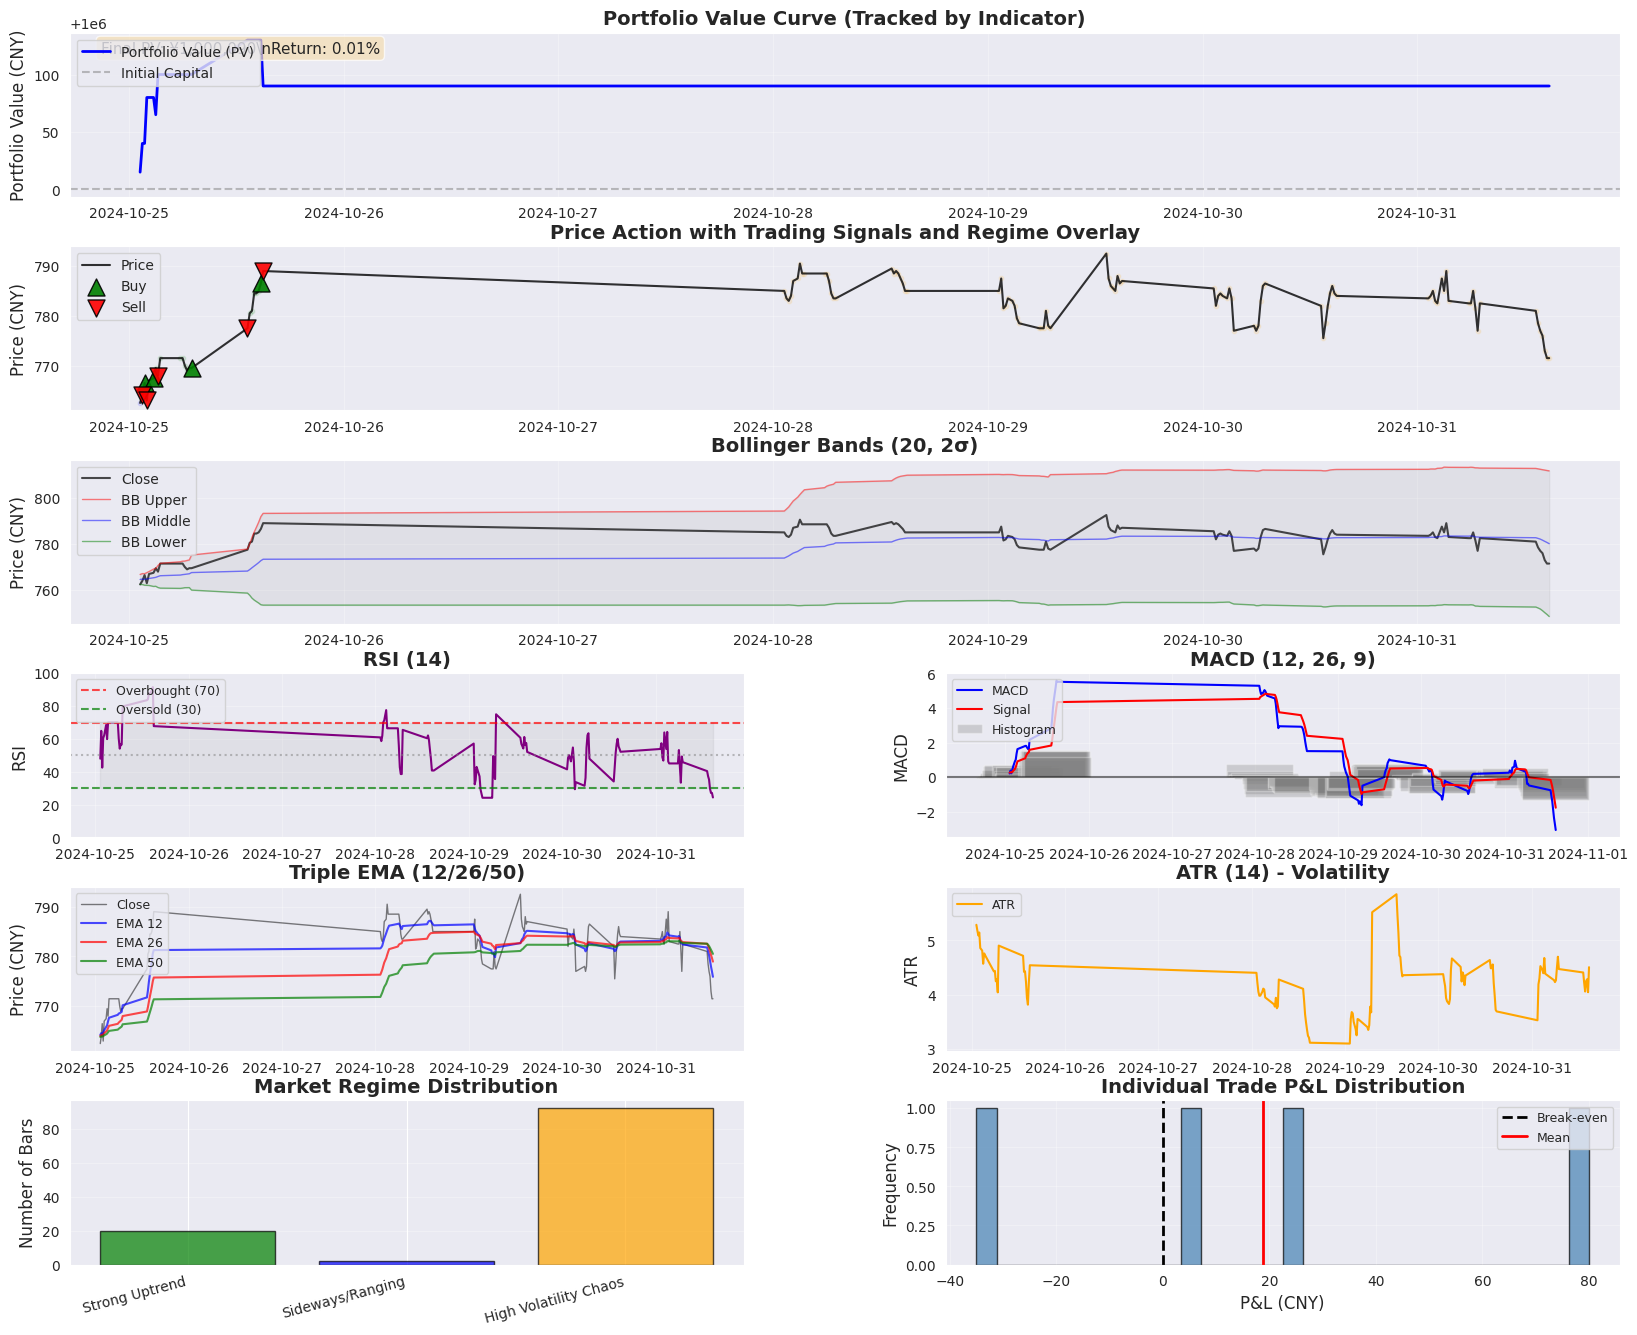

In [6]:
if df is not None and 'portfolio_value' in df.columns and len(trades_df) > 0:
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(6, 2, hspace=0.3, wspace=0.3)
    
    regime_colors = {1: 'green', 2: 'red', 3: 'blue', 4: 'orange'}
    
    # Panel 1: Portfolio Value Curve (from indicator)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df['timestamp'], df['portfolio_value'], linewidth=2, color='blue', label='Portfolio Value (PV)')
    ax1.axhline(y=1000000, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    ax1.set_title('Portfolio Value Curve (Tracked by Indicator)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Portfolio Value (CNY)', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    final_pv = df['portfolio_value'].iloc[-1]
    ax1.text(0.02, 0.95, f'Final PV: ¥{final_pv:,.0f}\\nReturn: {(final_pv/1000000-1)*100:.2f}%', 
             transform=ax1.transAxes, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # Panel 2: Price with Signals and Regime Background
    ax2 = fig.add_subplot(gs[1, :])
    
    # Color background by regime
    for regime_id, color in regime_colors.items():
        regime_df = df[df['regime'] == regime_id]
        if len(regime_df) > 0:
            ax2.scatter(regime_df['timestamp'], regime_df['close'], 
                       c=color, alpha=0.1, s=10)
    
    ax2.plot(df['timestamp'], df['close'], alpha=0.8, color='black', label='Price', linewidth=1.5)
    
    # Plot signals
    buy_signals = df[df['signal'] == 1]
    sell_signals = df[df['signal'] == -1]
    
    ax2.scatter(buy_signals['timestamp'], buy_signals['close'],
               color='green', marker='^', s=150, label='Buy', alpha=0.9, zorder=5, edgecolors='black')
    ax2.scatter(sell_signals['timestamp'], sell_signals['close'],
               color='red', marker='v', s=150, label='Sell', alpha=0.9, zorder=5, edgecolors='black')
    
    ax2.set_title('Price Action with Trading Signals and Regime Overlay', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Price (CNY)', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Bollinger Bands
    ax3 = fig.add_subplot(gs[2, :])
    ax3.plot(df['timestamp'], df['close'], alpha=0.7, color='black', label='Close', linewidth=1.5)
    ax3.plot(df['timestamp'], df['bb_upper'], alpha=0.5, color='red', label='BB Upper', linewidth=1)
    ax3.plot(df['timestamp'], df['bb_middle'], alpha=0.5, color='blue', label='BB Middle', linewidth=1)
    ax3.plot(df['timestamp'], df['bb_lower'], alpha=0.5, color='green', label='BB Lower', linewidth=1)
    ax3.fill_between(df['timestamp'], df['bb_upper'], df['bb_lower'], alpha=0.1, color='gray')
    ax3.set_title('Bollinger Bands (20, 2σ)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Price (CNY)', fontsize=12)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Panel 4: RSI
    ax4 = fig.add_subplot(gs[3, 0])
    ax4.plot(df['timestamp'], df['rsi'], color='purple', linewidth=1.5)
    ax4.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
    ax4.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
    ax4.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
    ax4.fill_between(df['timestamp'], 30, 70, alpha=0.1, color='gray')
    ax4.set_title('RSI (14)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('RSI', fontsize=12)
    ax4.set_ylim(0, 100)
    ax4.legend(loc='upper left', fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    # Panel 5: MACD
    ax5 = fig.add_subplot(gs[3, 1])
    ax5.plot(df['timestamp'], df['macd'], color='blue', linewidth=1.5, label='MACD')
    ax5.plot(df['timestamp'], df['macd_signal'], color='red', linewidth=1.5, label='Signal')
    ax5.bar(df['timestamp'], df['macd_histogram'], alpha=0.3, color='gray', label='Histogram')
    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax5.set_title('MACD (12, 26, 9)', fontsize=14, fontweight='bold')
    ax5.set_ylabel('MACD', fontsize=12)
    ax5.legend(loc='upper left', fontsize=9)
    ax5.grid(True, alpha=0.3)
    
    # Panel 6: Triple EMA
    ax6 = fig.add_subplot(gs[4, 0])
    ax6.plot(df['timestamp'], df['close'], alpha=0.5, color='black', label='Close', linewidth=1)
    ax6.plot(df['timestamp'], df['ema_12'], alpha=0.7, color='blue', label='EMA 12', linewidth=1.5)
    ax6.plot(df['timestamp'], df['ema_26'], alpha=0.7, color='red', label='EMA 26', linewidth=1.5)
    ax6.plot(df['timestamp'], df['ema_50'], alpha=0.7, color='green', label='EMA 50', linewidth=1.5)
    ax6.set_title('Triple EMA (12/26/50)', fontsize=14, fontweight='bold')
    ax6.set_ylabel('Price (CNY)', fontsize=12)
    ax6.legend(loc='upper left', fontsize=9)
    ax6.grid(True, alpha=0.3)
    
    # Panel 7: ATR (Volatility)
    ax7 = fig.add_subplot(gs[4, 1])
    ax7.plot(df['timestamp'], df['atr'], color='orange', linewidth=1.5, label='ATR')
    ax7.set_title('ATR (14) - Volatility', fontsize=14, fontweight='bold')
    ax7.set_ylabel('ATR', fontsize=12)
    ax7.legend(loc='upper left', fontsize=9)
    ax7.grid(True, alpha=0.3)
    
    # Panel 8: Regime Distribution
    ax8 = fig.add_subplot(gs[5, 0])
    regime_names = {1: 'Strong Uptrend', 2: 'Strong Downtrend', 3: 'Sideways/Ranging', 4: 'High Volatility Chaos'}
    regime_counts = df['regime'].value_counts().sort_index()
    regime_labels = [regime_names[i] for i in regime_counts.index]
    colors = [regime_colors[i] for i in regime_counts.index]
    ax8.bar(regime_labels, regime_counts.values, color=colors, alpha=0.7, edgecolor='black')
    ax8.set_title('Market Regime Distribution', fontsize=14, fontweight='bold')
    ax8.set_ylabel('Number of Bars', fontsize=12)
    ax8.grid(True, alpha=0.3, axis='y')
    plt.setp(ax8.xaxis.get_majorticklabels(), rotation=15, ha='right')
    
    # Panel 9: Trade P&L Distribution
    ax9 = fig.add_subplot(gs[5, 1])
    ax9.hist(trades_df['pnl'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax9.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Break-even')
    ax9.axvline(x=trades_df['pnl'].mean(), color='red', linestyle='-', linewidth=2, label='Mean')
    ax9.set_title('Individual Trade P&L Distribution', fontsize=14, fontweight='bold')
    ax9.set_xlabel('P&L (CNY)', fontsize=12)
    ax9.set_ylabel('Frequency', fontsize=12)
    ax9.legend(fontsize=9)
    ax9.grid(True, alpha=0.3)
    
    plt.savefig('analysis_comprehensive.png', dpi=150, bbox_inches='tight')
    print("\n✅ Comprehensive visualization saved as 'analysis_comprehensive.png'")
    plt.show()
else:
    print("⚠️ No data available for visualization (portfolio_value field required)")

## 7. Signal Confidence Analysis

📊 Signal Confidence Analysis:


/tmp/ipykernel_107381/1372557602.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confidence_analysis = trades_df.groupby(confidence_bins).agg({


pnl             return_pct
                 count   sum  mean       mean
confidence                                   
Low (0-0.3)          0   0.0   NaN        NaN
Medium (0.3-0.6)     1 -35.0 -35.0      -0.46
High (0.6-1.0)       0   0.0   NaN        NaN

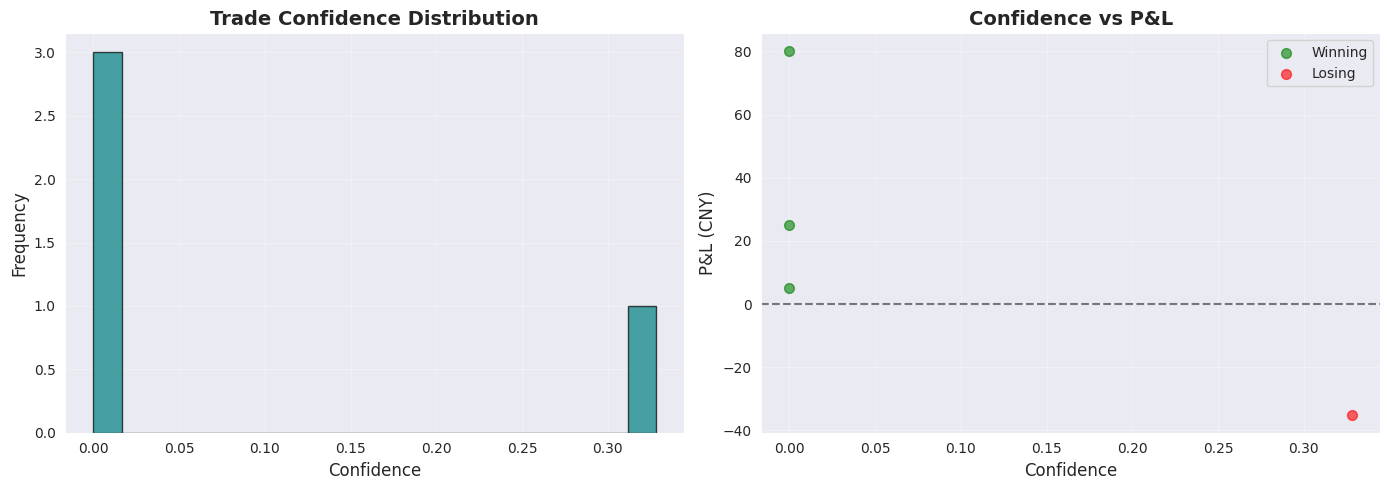

In [7]:
if df is not None and len(trades_df) > 0:
    print("📊 Signal Confidence Analysis:")
    print("="*70)
    
    # Analyze confidence vs P&L
    confidence_bins = pd.cut(trades_df['confidence'], bins=[0, 0.3, 0.6, 1.0], 
                            labels=['Low (0-0.3)', 'Medium (0.3-0.6)', 'High (0.6-1.0)'])
    
    confidence_analysis = trades_df.groupby(confidence_bins).agg({
        'pnl': ['count', 'sum', 'mean'],
        'return_pct': 'mean'
    }).round(2)
    
    display(confidence_analysis)
    
    # Visualize confidence vs outcome
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Confidence distribution
    axes[0].hist(trades_df['confidence'], bins=20, edgecolor='black', alpha=0.7, color='teal')
    axes[0].set_title('Trade Confidence Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Confidence', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Confidence vs P&L scatter
    winning = trades_df[trades_df['pnl'] > 0]
    losing = trades_df[trades_df['pnl'] <= 0]
    
    axes[1].scatter(winning['confidence'], winning['pnl'], 
                   color='green', alpha=0.6, s=50, label='Winning')
    axes[1].scatter(losing['confidence'], losing['pnl'], 
                   color='red', alpha=0.6, s=50, label='Losing')
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1].set_title('Confidence vs P&L', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Confidence', fontsize=12)
    axes[1].set_ylabel('P&L (CNY)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Monthly Performance Breakdown

📅 Monthly Performance:


/tmp/ipykernel_107381/603016750.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  trades_df['month'] = pd.to_datetime(trades_df['exit_time']).dt.to_period('M')


pnl              return_pct
          sum count   mean       mean
month                                
2024-10  75.0     4  18.75       0.24

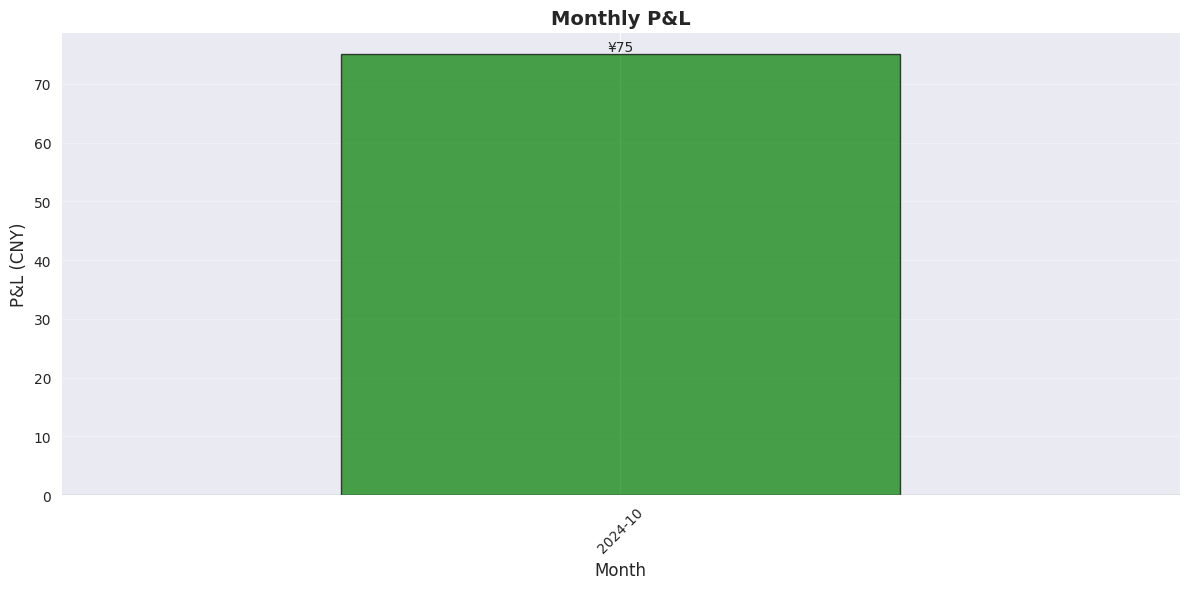

In [8]:
if df is not None and len(trades_df) > 0:
    print("📅 Monthly Performance:")
    print("="*70)
    
    # Add month column to trades
    trades_df['month'] = pd.to_datetime(trades_df['exit_time']).dt.to_period('M')
    
    monthly_pnl = trades_df.groupby('month').agg({
        'pnl': ['sum', 'count', 'mean'],
        'return_pct': 'mean'
    }).round(2)
    
    display(monthly_pnl)
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    monthly_totals = trades_df.groupby('month')['pnl'].sum()
    colors = ['green' if x > 0 else 'red' for x in monthly_totals]
    monthly_totals.plot(kind='bar', ax=ax, color=colors, edgecolor='black', alpha=0.7)
    ax.set_title('Monthly P&L', fontsize=14, fontweight='bold')
    ax.set_ylabel('P&L (CNY)', fontsize=12)
    ax.set_xlabel('Month', fontsize=12)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    
    # Add value labels
    for i, v in enumerate(monthly_totals):
        ax.text(i, v, f'¥{v:,.0f}', ha='center', 
               va='bottom' if v > 0 else 'top', fontsize=10)
    
    plt.tight_layout()
    plt.show()

## 9. Summary and Evaluation

In [9]:
if metrics:
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    
    print(f"Period: {df['timestamp'].min().date()} to {df['timestamp'].max().date()}")
    print(f"Total Bars: {len(df)}")
    print(f"Total Trades: {metrics['Total Trades']}")
    print(f"Total P&L: ¥{metrics['Total P&L (CNY)']:,.2f}")
    print(f"Total Return: {metrics['Total Return (%)']:.2f}%")
    print(f"Win Rate: {metrics['Win Rate']:.2%}")
    print(f"Profit Factor: {metrics['Profit Factor']:.2f}")
    print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
    print(f"Max Drawdown: {metrics['Max Drawdown (%)']:.2f}%")
    
    print("\n" + "="*70)
    print("EVALUATION AGAINST CRITERIA")
    print("="*70)
    
    # Evaluation criteria
    criteria = [
        ("✅" if metrics['Sharpe Ratio'] > 1.0 else "❌", 
         f"Sharpe Ratio > 1.0: {metrics['Sharpe Ratio']:.2f}"),
        ("✅" if metrics['Win Rate'] > 0.5 else "❌", 
         f"Win Rate > 50%: {metrics['Win Rate']:.2%}"),
        ("✅" if metrics['Profit Factor'] > 1.5 else "❌", 
         f"Profit Factor > 1.5: {metrics['Profit Factor']:.2f}"),
        ("✅" if abs(metrics['Max Drawdown (%)']) < 20 else "❌", 
         f"Max Drawdown < 20%: {abs(metrics['Max Drawdown (%)']):.2f}%"),
        ("✅" if metrics['Total P&L (CNY)'] > 0 else "❌", 
         f"Total P&L > 0: ¥{metrics['Total P&L (CNY)']:,.2f}"),
        ("✅" if metrics['Total Return (%)'] > 5 else "❌", 
         f"Total Return > 5%: {metrics['Total Return (%)']:.2f}%")
    ]
    
    for status, criterion in criteria:
        print(f"{status} {criterion}")
    
    passed = sum(1 for status, _ in criteria if status == "✅")
    print(f"\n📊 Passed: {passed}/{len(criteria)} criteria")
    
    if passed >= 5:
        print("\n🎉 Strategy shows strong performance! Ready for production consideration.")
    elif passed >= 3:
        print("\n⚠️ Strategy shows potential but needs optimization.")
    else:
        print("\n❌ Strategy needs significant improvement before production.")
    
    print("="*70)
else:
    print("\n❌ No metrics available for evaluation")


SUMMARY
Period: 2024-10-25 to 2024-10-31
Total Bars: 114
Total Trades: 4
Total P&L: ¥75.00
Total Return: 0.01%
Win Rate: 75.00%
Profit Factor: 3.14
Sharpe Ratio: 6.16
Max Drawdown: -0.00%

EVALUATION AGAINST CRITERIA
✅ Sharpe Ratio > 1.0: 6.16
✅ Win Rate > 50%: 75.00%
✅ Profit Factor > 1.5: 3.14
✅ Max Drawdown < 20%: 0.00%
✅ Total P&L > 0: ¥75.00
❌ Total Return > 5%: 0.01%

📊 Passed: 5/6 criteria

🎉 Strategy shows strong performance! Ready for production consideration.


## 10. Export Results

In [10]:
if df is not None and 'portfolio_value' in df.columns and len(trades_df) > 0:
    # Export trades to CSV
    trades_df.to_csv('trades_analysis.csv', index=False)
    print("✅ Trades exported to 'trades_analysis.csv'")
    
    # Export portfolio tracking data (from indicator)
    portfolio_export = df[['timestamp', 'portfolio_value', 'cash', 'contracts_held', 'regime', 'signal', 'confidence']].copy()
    portfolio_export.to_csv('portfolio_tracking.csv', index=False)
    print("✅ Portfolio tracking data exported to 'portfolio_tracking.csv'")
    
    # Export metrics
    if metrics:
        metrics_df = pd.DataFrame([metrics])
        metrics_df.to_csv('performance_metrics.csv', index=False)
        print("✅ Metrics exported to 'performance_metrics.csv'")
    
    print("\n✅ All analysis complete!")
    print(f"\n📊 Final Results:")
    print(f"   Initial Capital: ¥1,000,000")
    print(f"   Final PV: ¥{df['portfolio_value'].iloc[-1]:,.2f}")
    print(f"   Total Return: {(df['portfolio_value'].iloc[-1]/1000000-1)*100:.2f}%")
    print(f"   Total Trades: {len(trades_df)}")
else:
    print("⚠️ No data to export (portfolio_value field required)")

✅ Trades exported to 'trades_analysis.csv'
✅ Portfolio tracking data exported to 'portfolio_tracking.csv'
✅ Metrics exported to 'performance_metrics.csv'

✅ All analysis complete!

📊 Final Results:
   Initial Capital: ¥1,000,000
   Final PV: ¥1,000,090.00
   Total Return: 0.01%
   Total Trades: 4
